# Data and main parameters

In [240]:
import math
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'datasets/'
# !git clone https://github.com/lqwic/deep_var.git
# %cd deep_var/

In [352]:
def load_data(file_path):
    return pd.read_csv(file_path, index_col='Date', parse_dates=True)

stocks = load_data(data_path + 'stocks.csv')
commodities = load_data(data_path + 'commodities.csv')
crypto = load_data(data_path + 'cryptos.csv')

window_size = 21
alpha = 99
train_size = 0.8
data = commodities

In [353]:
import numpy as np
from scipy.stats import pareto
from ot import emd2

def multivariate_pareto_sample(alpha, theta, size):
    d = len(theta)
    samples = np.zeros((size, d))
    for i in range(d):
        samples[:, i] = pareto.rvs(alpha, scale=theta[i], size=size)
    return samples

# Parameters for the two multivariate Pareto distributions
alpha1, theta1 = 3, np.array([1, 2, 3])
alpha2, theta2 = 2, np.array([2, 3, 4])

# Generate samples from the distributions
n_samples = 1000
samples_P = multivariate_pareto_sample(alpha1, theta1, n_samples)
samples_Q = multivariate_pareto_sample(alpha2, theta2, n_samples)

# Compute the Wasserstein distance
M = np.sqrt(np.sum((samples_P[:, np.newaxis] - samples_Q[np.newaxis, :])**2, axis=2))
wasserstein_distance = emd2(np.ones(n_samples) / n_samples, np.ones(n_samples) / n_samples, M)

print(f"Approximate Wasserstein distance: {wasserstein_distance}")

Approximate Wasserstein distance: 5.932443770386223


# Test Model

In [354]:
from ot import wasserstein_1d

class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers

        self.encoder = nn.GRU(input_size=input_size + latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Encoder
        self.encoder_theta = nn.Linear(hidden_size, latent_size)
        self.alpha = nn.Parameter(torch.ones(1))  # Learnable alpha parameter

        # Decoder
        self.decoder_out = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hist_vol):
        batch_size, seq_length, input_size = x.size()
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        z_prev = torch.ones(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)
        
        z_list = []
        r_list = []
        theta_z_list = []
        
        for t in range(seq_length):
            # Encoder
            encoder_input = torch.cat([x[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = self.encoder(encoder_input.unsqueeze(1), h_enc)
            h_enc = self.dropout(h_enc)
            theta_z = F.softplus(self.encoder_theta(h_enc[-1])) + 1e-6
            z = self.reparameterize_pareto(theta_z)
            z_list.append(z)
            theta_z_list.append(theta_z)
            z_prev = z
        
            # Decoder
            decoder_input = torch.cat([z, r_prev, hist_vol], dim=-1)
            _, h_dec = self.decoder(decoder_input.unsqueeze(1), h_dec)
            h_dec = self.dropout(h_dec)
            r = self.decoder_out(h_dec[-1])
            r_list.append(r)
            r_prev = x[:, t, :]
        
        z_list = torch.stack(z_list, dim=1)  # (batch_size, seq_length, latent_size)
        r_list = torch.stack(r_list, dim=1)  # (batch_size, seq_length, input_size)
        theta_z_list = torch.stack(theta_z_list, dim=1)  # (batch_size, seq_length, latent_size)
        
        wasserstein_loss = self.wasserstein_loss(z_list)
        recon_loss, recon_loss_vol = self.reconstruction_loss(r_list, x)
        return wasserstein_loss, recon_loss, recon_loss_vol, z_list, r_list, theta_z_list
        
    def reparameterize_pareto(self, theta):
        u = torch.rand_like(theta)
        return theta / torch.pow(u, 1 / F.softplus(self.alpha))

    def wasserstein_loss(self, z_list):
        z_diff = z_list[:, 1:] - z_list[:, :-1]
        wasserstein_dist = torch.mean(wasserstein_1d(z_diff[:, :-1], z_diff[:, 1:]))
        return wasserstein_dist

    def reconstruction_loss(self, r, x):
        recon_loss_mean = F.mse_loss(r[:, :, :-1], x[:, :, :-1], reduction='sum')
        recon_loss_vol = F.mse_loss(r[:, :, -1], x[:, :, -1], reduction='sum')
        recon_loss = recon_loss_mean + recon_loss_vol
        return recon_loss, recon_loss_vol

In [355]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(13, 16, 10, 1).to(device)

r_prev = torch.rand(256, 100, 13).to(device)
hist_vol = torch.rand(256, 13).to(device)

kld_loss, recon_loss, recon_loss_vol, z_list, r_list, theta_z_list = model(r_prev, hist_vol)

print("Reconstructed output:")
print(r_list[0][0])
print("Original input:")
print(r_prev[0][0])

Reconstructed output:
tensor([ 0.2010,  0.0535, -0.2395, -0.2179, -0.0080, -0.5217, -0.0861, -0.2008,
        -0.1291, -0.3292, -0.3321, -0.1167,  0.0411],
       grad_fn=<SelectBackward0>)
Original input:
tensor([0.8688, 0.0440, 0.1547, 0.7148, 0.3597, 0.5916, 0.1999, 0.1471, 0.8650,
        0.6549, 0.5881, 0.7750, 0.4335])


# Model

In [356]:
from ot import wasserstein_1d

class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1, recon_loss_vol_weight=1.0):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.recon_loss_vol_weight = recon_loss_vol_weight

        self.encoder = nn.GRU(input_size=input_size + latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Encoder
        self.encoder_theta = nn.Linear(hidden_size, latent_size)
        self.alpha = nn.Parameter(torch.ones(1))  # Learnable alpha parameter

        # Decoder
        self.decoder_out = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hist_vol):
        batch_size, seq_length, input_size = x.size()
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        z_prev = torch.ones(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)
        
        z_list = []
        r_list = []
        theta_z_list = []
        
        for t in range(seq_length):
            # Encoder
            encoder_input = torch.cat([x[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = self.encoder(encoder_input.unsqueeze(1), h_enc)
            h_enc = self.dropout(h_enc)
            theta_z = F.softplus(self.encoder_theta(h_enc[-1])) + 1e-6
            z = self.reparameterize_pareto(theta_z)
            z_list.append(z)
            theta_z_list.append(theta_z)
            z_prev = z
        
            # Decoder
            decoder_input = torch.cat([z, r_prev, hist_vol], dim=-1)
            _, h_dec = self.decoder(decoder_input.unsqueeze(1), h_dec)
            h_dec = self.dropout(h_dec)
            r = self.decoder_out(h_dec[-1])
            r_list.append(r)
            r_prev = x[:, t, :]
        
        z_list = torch.stack(z_list, dim=1)  # (batch_size, seq_length, latent_size)
        r_list = torch.stack(r_list, dim=1)  # (batch_size, seq_length, input_size)
        theta_z_list = torch.stack(theta_z_list, dim=1)  # (batch_size, seq_length, latent_size)
        
        wasserstein_loss = self.wasserstein_loss(z_list)
        recon_loss, recon_loss_vol = self.reconstruction_loss(r_list, x)
        return wasserstein_loss, recon_loss, recon_loss_vol, z_list, r_list, theta_z_list
        
    def reparameterize_pareto(self, theta):
        u = torch.rand_like(theta)
        return theta / torch.pow(u, 1 / F.softplus(self.alpha))

    def wasserstein_loss(self, z_list):
        # Use a more accurate Wasserstein distance approximation
        # For example, using the POT library:
        z_diff = z_list[:, 1:] - z_list[:, :-1]
        z_diff = torch.clamp(z_diff, min=-1e6, max=1e6)
        wasserstein_dist = torch.mean(wasserstein_1d(z_diff[:, :-1], z_diff[:, 1:]))
        return wasserstein_dist

    def reconstruction_loss(self, r, x):
        recon_loss_mean = F.mse_loss(r[:, :, :-1], x[:, :, :-1], reduction='sum')
        recon_loss_vol = F.mse_loss(r[:, :, -1], x[:, :, -1], reduction='sum')
        recon_loss = recon_loss_mean + self.recon_loss_vol_weight * recon_loss_vol
        return recon_loss, recon_loss_vol

# Training

In [357]:
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(data, seq_length=21, train_ratio=0.66):
    data = data.values
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std

    # Calculate historical volatility (e.g., using rolling standard deviation)
    hist_vol = pd.DataFrame(data).rolling(window=seq_length).std().values

    sequences = []
    hist_vols = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(torch.tensor(data[i:i+seq_length], dtype=torch.float32))
        hist_vols.append(torch.tensor(hist_vol[i+seq_length-1], dtype=torch.float32))

    hist_vol = hist_vol[~np.isnan(hist_vol)]

    train_size = int(train_ratio * len(sequences))
    train_sequences = sequences[:train_size]
    train_hist_vols = hist_vols[:train_size]
    test_sequences = sequences[train_size - seq_length:]
    test_hist_vols = hist_vols[train_size - seq_length:]

    train_dataset = TensorDataset(torch.stack(train_sequences), torch.stack(train_hist_vols))
    test_dataset = TensorDataset(torch.stack(test_sequences), torch.stack(test_hist_vols))

    return train_dataset, test_dataset, data_mean, data_std

In [358]:
seq_length = 10
batch_size = 256
train_dataset, test_dataset, data_mean, data_std = preprocess_data(data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [359]:
def train(model, train_loader, optimizer, device=torch.device('cpu'), alpha=0.5, beta=1.0, l1_reg=0.001):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_recon_loss_vol = 0
    train_wasserstein_loss = 0

    for batch in train_loader:
        seq_batch, vol_batch = batch
        seq_batch = seq_batch.to(device)

        optimizer.zero_grad()
        wasserstein_loss, recon_loss, recon_loss_vol, _, _, _ = model(seq_batch, vol_batch)
        loss = alpha * wasserstein_loss + beta * recon_loss + l1_reg * torch.norm(model.encoder_theta.weight, p=1)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_recon_loss_vol += recon_loss_vol.item()
        train_wasserstein_loss += wasserstein_loss.item()

        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_recon_loss_vol /= len(train_loader.dataset)
    train_wasserstein_loss /= len(train_loader.dataset)

    return train_loss, train_recon_loss, train_recon_loss_vol, train_wasserstein_loss

def test(model, test_loader, device=torch.device('cpu')):
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_recon_loss_vol = 0
    test_wasserstein_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            seq_batch, vol_batch = batch
            seq_batch = seq_batch.to(device)

            wasserstein_loss, recon_loss, recon_loss_vol, _, _, _ = model(seq_batch, vol_batch)
            loss = wasserstein_loss + recon_loss

            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_recon_loss_vol += recon_loss_vol.item()
            test_wasserstein_loss += wasserstein_loss.item()

    test_loss /= len(test_loader.dataset)
    test_recon_loss /= len(test_loader.dataset)
    test_recon_loss_vol /= len(test_loader.dataset)
    test_wasserstein_loss /= len(test_loader.dataset)

    return test_loss, test_recon_loss, test_recon_loss_vol, test_wasserstein_loss

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 48.0674, Train Recon Loss: 48.0619, Train Recon Loss Vol: 13.3261, Train Wasserstein Loss: 0.0110, Test Loss: 31.6398, Test Recon Loss: 31.6276, Test Recon Loss Vol: 5.8400, Test Wasserstein Loss: 0.0122
Epoch [20/1000], Train Loss: 47.3163, Train Recon Loss: 47.3106, Train Recon Loss Vol: 13.3707, Train Wasserstein Loss: 0.0113, Test Loss: 31.0041, Test Recon Loss: 30.9911, Test Recon Loss Vol: 5.8014, Test Wasserstein Loss: 0.0130
Epoch [30/1000], Train Loss: 46.6471, Train Recon Loss: 46.6409, Train Recon Loss Vol: 13.3530, Train Wasserstein Loss: 0.0125, Test Loss: 30.5050, Test Recon Loss: 30.4953, Test Recon Loss Vol: 5.7880, Test Wasserstein Loss: 0.0097
Epoch [40/1000], Train Loss: 46.2223, Train Recon Loss: 46.2176, Train Recon Loss Vol: 13.3037, Train Wasserstein Loss: 0.0093, Test Loss: 30.2332, Test Recon Loss: 30.2244, Test Recon Loss Vol: 5.7834, Test Wasserstein Loss: 0.0089
Epoch [50/1000], Train Loss: 45.7908, Train Recon Loss: 45.7869, Tra

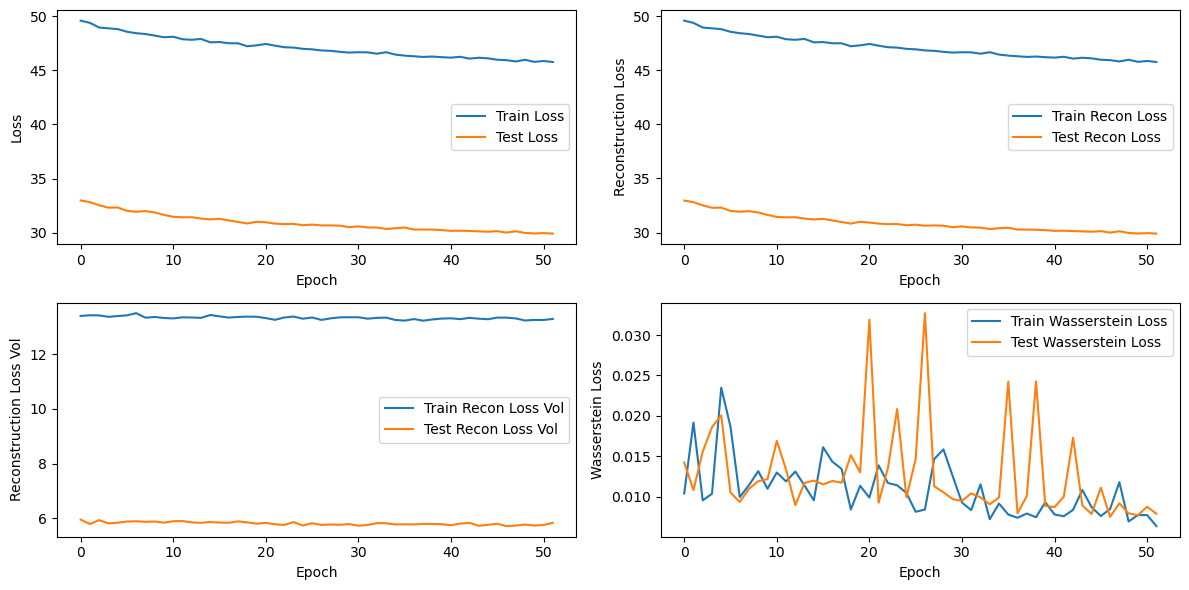

KeyboardInterrupt: 

In [360]:
import os

input_dim = data.shape[1]
latent_dim = 10
hidden_dim = 16
num_layers = 1
learning_rate = 0.0001
epochs = 1000
save_interval = 100
plot_interval = 100
decay_rate = 0.96
decay_steps = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers, dropout_rate=0.1, recon_loss_vol_weight=0.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

save_dir = 'paretoHVVAE_checkpoints'
os.makedirs(save_dir, exist_ok=True)

train_losses = []
test_losses = []
train_recon_losses = []
test_recon_losses = []
train_recon_losses_vol = []
test_recon_losses_vol = []
train_wasserstein_losses = []
test_wasserstein_losses = []

for epoch in trange(1, epochs+1):
    train_loss, train_recon_loss, train_recon_loss_vol, train_wasserstein_loss = train(model, train_loader, optimizer, device, alpha=0.5, beta=1.0, l1_reg=0.0001)
    test_loss, test_recon_loss, test_recon_loss_vol, test_wasserstein_loss = test(model, test_loader, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_recon_losses_vol.append(train_recon_loss_vol)
    test_recon_losses_vol.append(test_recon_loss_vol)
    train_wasserstein_losses.append(train_wasserstein_loss)
    test_wasserstein_losses.append(test_wasserstein_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train Recon Loss Vol: {train_recon_loss_vol:.4f}, "
              f"Train Wasserstein Loss: {train_wasserstein_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test Recon Loss Vol: {test_recon_loss_vol:.4f}, "
              f"Test Wasserstein Loss: {test_wasserstein_loss:.4f}")
    
    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
    
    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
        plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss Vol')
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.plot(train_wasserstein_losses, label='Train Wasserstein Loss')
        plt.plot(test_wasserstein_losses, label='Test Wasserstein Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Wasserstein Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training Plot

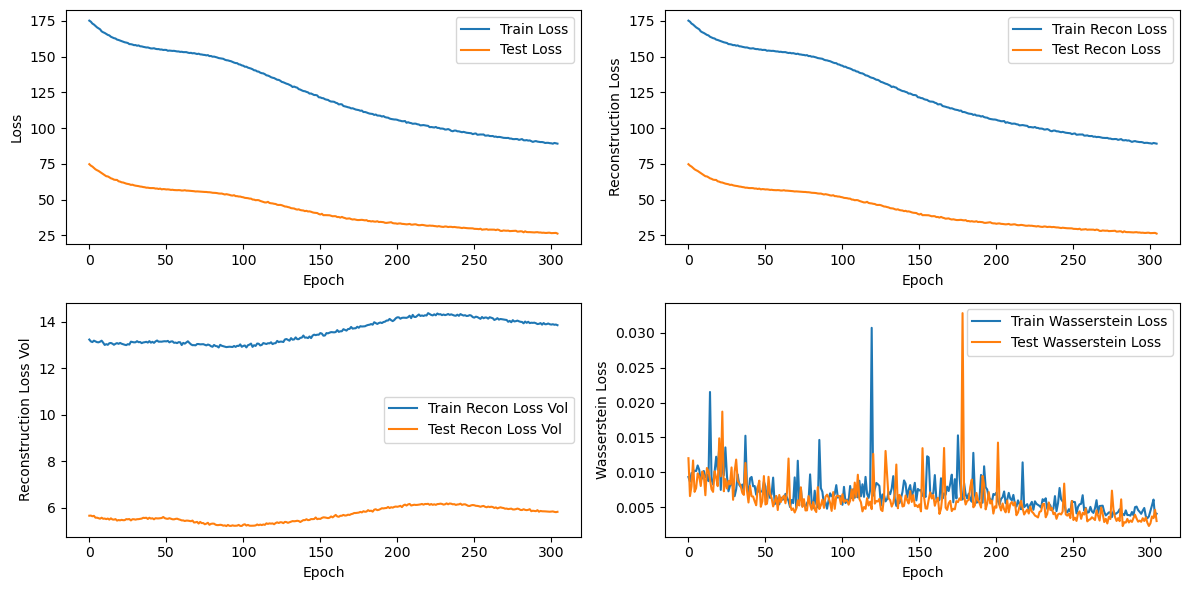

In [338]:
plt.figure(figsize=(12, 6))
        
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_recon_losses, label='Train Recon Loss')
plt.plot(test_recon_losses, label='Test Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss Vol')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_wasserstein_losses, label='Train Wasserstein Loss')
plt.plot(test_wasserstein_losses, label='Test Wasserstein Loss')
plt.xlabel('Epoch')
plt.ylabel('Wasserstein Loss')
plt.legend()

plt.tight_layout()
plt.savefig(f"ParetoWassHVVAE_training_plot.png")
plt.show()

# Further training

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch [500/1000], Train Loss: 169.5194, Train Recon Loss: 169.5143, Train Recon Loss Vol: 13.6278, Train Wasserstein Loss: 0.0102, Test Loss: 63.2730, Test Recon Loss: 63.2627, Test Recon Loss Vol: 5.6072, Test Wasserstein Loss: 0.0103


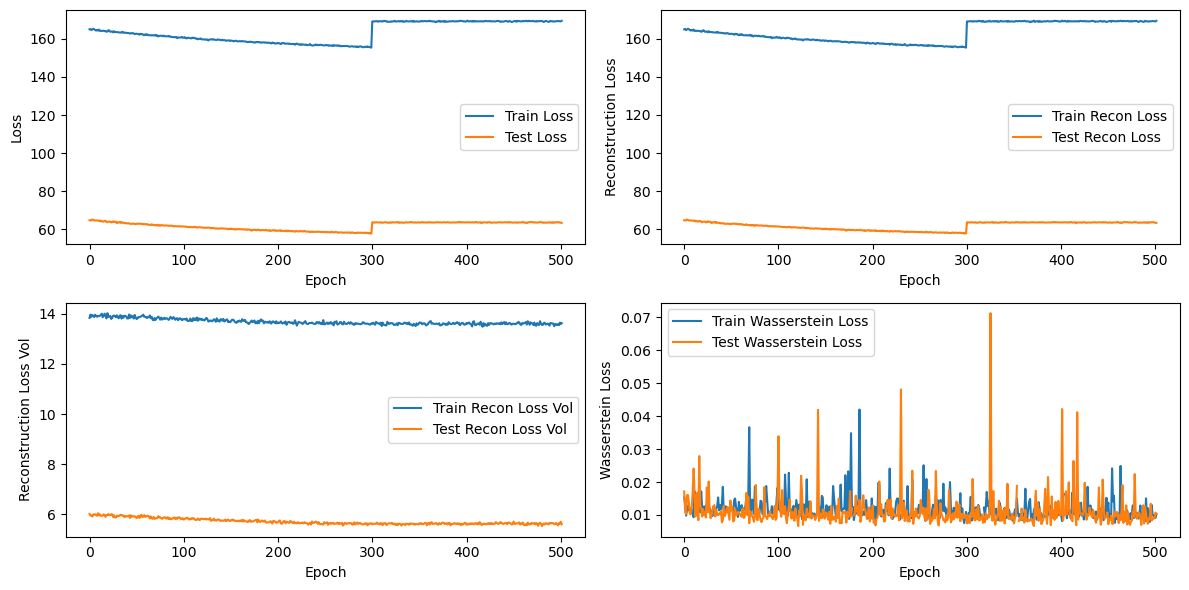

Epoch [510/1000], Train Loss: 169.0512, Train Recon Loss: 169.0470, Train Recon Loss Vol: 13.6134, Train Wasserstein Loss: 0.0083, Test Loss: 63.6246, Test Recon Loss: 63.6132, Test Recon Loss Vol: 5.6696, Test Wasserstein Loss: 0.0114
Epoch [520/1000], Train Loss: 169.1334, Train Recon Loss: 169.1287, Train Recon Loss Vol: 13.5795, Train Wasserstein Loss: 0.0094, Test Loss: 63.4647, Test Recon Loss: 63.4548, Test Recon Loss Vol: 5.6329, Test Wasserstein Loss: 0.0099
Epoch [530/1000], Train Loss: nan, Train Recon Loss: 169.2026, Train Recon Loss Vol: 13.6050, Train Wasserstein Loss: nan, Test Loss: 63.3999, Test Recon Loss: 63.3907, Test Recon Loss Vol: 5.6747, Test Wasserstein Loss: 0.0092
Epoch [540/1000], Train Loss: 169.6967, Train Recon Loss: 169.6905, Train Recon Loss Vol: 13.6036, Train Wasserstein Loss: 0.0123, Test Loss: 63.5346, Test Recon Loss: 63.5243, Test Recon Loss Vol: 5.6701, Test Wasserstein Loss: 0.0103
Epoch [550/1000], Train Loss: 169.2401, Train Recon Loss: 169.23

KeyboardInterrupt: 

In [323]:
end_epoch = 500
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.load_state_dict(torch.load(save_dir + '/model_epoch_500.pth'))

epochs = 1000

model.train()
for epoch in trange(end_epoch, epochs+1):
    train_loss, train_recon_loss, train_recon_loss_vol, train_wasserstein_loss = train(model, train_loader, optimizer, device, alpha=0.5, beta=1.0, l1_reg=0.0001)
    test_loss, test_recon_loss, test_recon_loss_vol, test_wasserstein_loss = test(model, test_loader, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_recon_losses_vol.append(train_recon_loss_vol)
    test_recon_losses_vol.append(test_recon_loss_vol)
    train_wasserstein_losses.append(train_wasserstein_loss)
    test_wasserstein_losses.append(test_wasserstein_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train Recon Loss Vol: {train_recon_loss_vol:.4f}, "
              f"Train Wasserstein Loss: {train_wasserstein_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test Recon Loss Vol: {test_recon_loss_vol:.4f}, "
              f"Test Wasserstein Loss: {test_wasserstein_loss:.4f}")
    
    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
    
    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
        plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss Vol')
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.plot(train_wasserstein_losses, label='Train Wasserstein Loss')
        plt.plot(test_wasserstein_losses, label='Test Wasserstein Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Wasserstein Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Final model

In [335]:
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.load_state_dict(torch.load('model_checkpoints/model_epoch_300.pth'))

<All keys matched successfully>

# Testing randomness

In [336]:
model.eval()
historical_returns, hist_vol = next(iter(test_loader))
historical_returns = historical_returns.to(device)
hist_vol = hist_vol.to(device)

with torch.no_grad():
    kld_loss, recon_loss, recon_loss_vol, z_list, r_list, theta_z_list = model(historical_returns, hist_vol)

print(f"Input sequence (historical_returns) of {historical_returns.shape}:")
print(historical_returns[0][0])
print(f"Generated r_list of {r_list.shape}:")
print(r_list[0][0])

Input sequence (historical_returns) of torch.Size([256, 10, 13]):
tensor([ 1.8522e+00, -2.8894e-01, -3.7388e-01,  1.0434e-03, -3.6123e-01,
        -1.4449e-01, -5.2565e-01, -5.1718e-01,  8.6074e-02, -2.1663e-02,
         5.8024e-01, -3.2302e-01, -3.6452e-01])
Generated r_list of torch.Size([256, 10, 13]):
tensor([-0.3000, -0.2971, -0.2476, -0.1814, -0.2617, -0.1579, -0.2648, -0.3303,
        -0.1462, -0.0547, -0.1891, -0.2698,  0.0932])


[[0.26979542 0.61209756 0.5920678  ... 1.0636293  2.0053413  8.36162   ]
 [0.3817188  1.3806492  2.5913143  ... 2.113639   2.5718524  8.389842  ]
 [0.7998508  3.809389   2.5453427  ... 2.8943942  2.053417   2.7351713 ]
 ...
 [0.29663742 0.21099137 0.11236807 ... 0.5348493  0.35778725 0.11169507]
 [0.18871288 0.18946904 0.5676096  ... 0.4439513  0.6076262  0.16443098]
 [0.19575727 0.3309702  0.22330849 ... 0.17785227 0.54517025 0.15209313]]


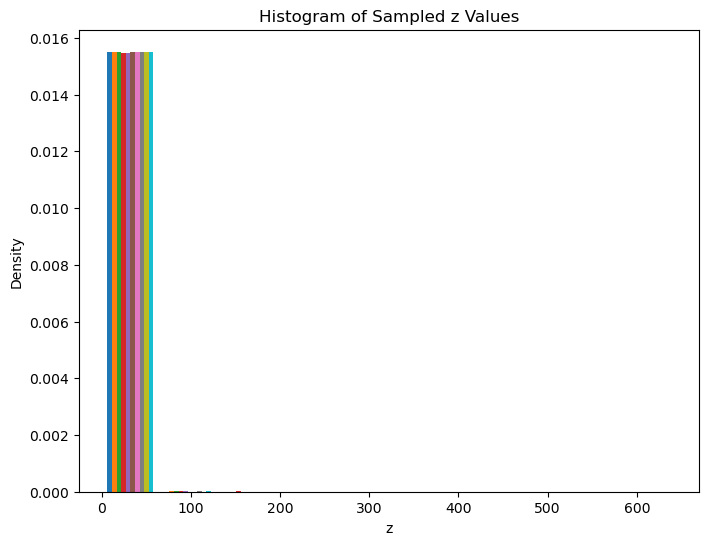

In [337]:
z_samples = torch.zeros_like(theta_z_list)
for t in range(theta_z_list.size(1)):
    z_samples[:, t, :] = model.reparameterize_pareto(theta_z_list[:, t, :])

z_samples = z_samples.view(-1, model.latent_size).detach().numpy()
print(z_samples)

plt.figure(figsize=(8, 6))
plt.hist(z_samples, density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Histogram of Sampled z Values')
plt.show()

# VaR Forecasting

In [339]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()

DSVM(
  (encoder): GRU(36, 16, batch_first=True)
  (decoder): GRU(36, 16, batch_first=True)
  (encoder_theta): Linear(in_features=16, out_features=10, bias=True)
  (decoder_out): Linear(in_features=16, out_features=13, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [341]:
portfolio_weights = np.loadtxt('weights_crypto99.csv', delimiter=',')
portfolio_weights = torch.tensor(portfolio_weights, dtype=torch.float32, device=device)

In [342]:
def one_step_ahead_forecast(model, historical_returns, hist_vol, portfolio_weights, num_samples=1000, device=torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        batch_size, seq_length, _ = historical_returns.shape
        h_enc = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        h_dec = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        z_prev = torch.ones(batch_size, model.latent_size).to(device)
        
        for t in range(seq_length):
            encoder_input = torch.cat([historical_returns[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = model.encoder(encoder_input.unsqueeze(1), h_enc)
            theta_z = F.softplus(model.encoder_theta(h_enc[-1])) + 1e-6
            z_prev = model.reparameterize_pareto(theta_z)
        
        z_samples = []
        for _ in range(num_samples):
            z_sample = model.reparameterize_pareto(theta_z)
            z_samples.append(z_sample)
        z_samples = torch.stack(z_samples)
        
        forecasts = []
        for z_sample in z_samples:
            decoder_input = torch.cat([z_sample, historical_returns[:, -1, :], hist_vol], dim=-1)
            _, h_dec = model.decoder(decoder_input.unsqueeze(1), h_dec)
            forecast = model.decoder_out(h_dec[-1])
            forecasts.append(forecast.squeeze())
        
        forecasts = torch.stack(forecasts)
        portfolio_forecasts = torch.matmul(forecasts, portfolio_weights)
        point_forecast = portfolio_forecasts.mean().item()
        lower_quantile = torch.quantile(portfolio_forecasts, 0.01).item()
        
        return point_forecast, lower_quantile

In [343]:
from tqdm import tqdm
def generate_forecasts(model, test_loader, portfolio_weights, device=torch.device('cpu')):
    model.eval()
    point_forecasts = []
    lower_quantiles = []
    actual_values = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating Forecasts"):
            historical_returns, hist_vol = batch
            historical_returns = historical_returns.to(device)
            hist_vol = hist_vol.to(device)
            
            point_forecast, lower_quantile = one_step_ahead_forecast(model, historical_returns, hist_vol, portfolio_weights, device=device)
            point_forecasts.append(point_forecast)
            lower_quantiles.append(lower_quantile)
            actual_values.append(torch.matmul(historical_returns[:, -1, :], portfolio_weights).item())
    
    return point_forecasts, lower_quantiles, actual_values

Generating Forecasts: 100%|███████████████████| 752/752 [01:11<00:00, 10.58it/s]


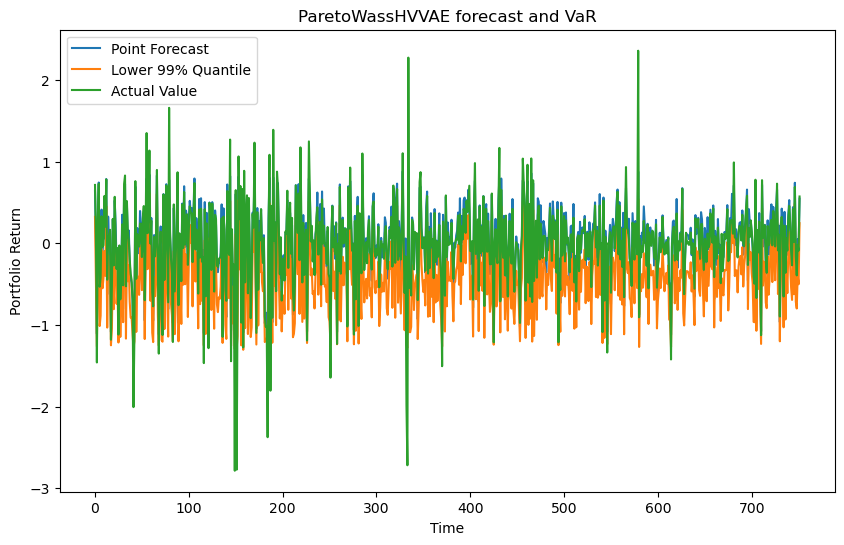

In [344]:
point_forecasts, lower_quantiles, actual_values = generate_forecasts(model, test_loader, portfolio_weights, device=device)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(point_forecasts, label='Point Forecast')
plt.plot(lower_quantiles, label='Lower 99% Quantile')
plt.plot(actual_values, label='Actual Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Return')
plt.title('ParetoWassHVVAE forecast and VaR')
plt.legend()
plt.savefig(f"ParetoWassHVVAE_forecast_plot.png")
plt.show()

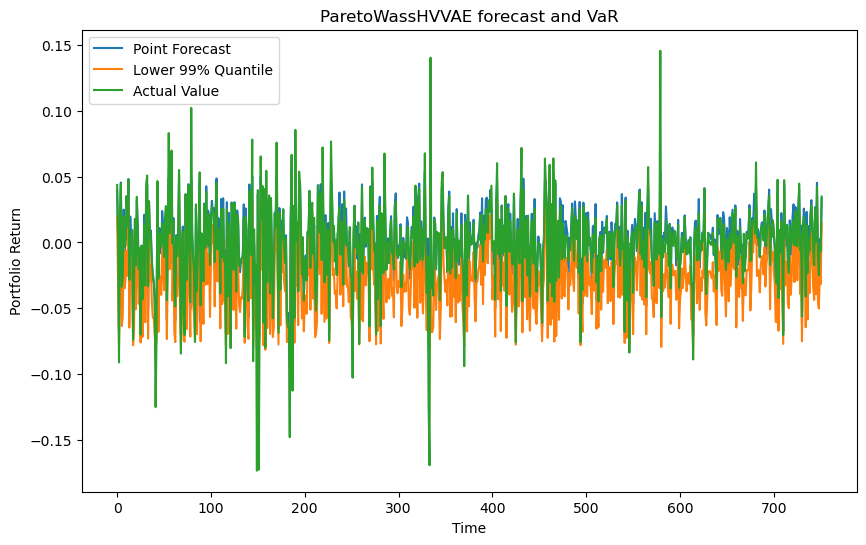

In [345]:
point_forecasts_renorm = np.array(point_forecasts) * data_std[-1] + data_mean[-1]
lower_quantiles_renorm = np.array(lower_quantiles) * data_std[-1] + data_mean[-1]
actual_values_renorm = np.array(actual_values) * data_std[-1] + data_mean[-1]

plt.figure(figsize=(10, 6))
plt.plot(point_forecasts_renorm, label='Point Forecast')
plt.plot(lower_quantiles_renorm, label='Lower 99% Quantile')
plt.plot(actual_values_renorm, label='Actual Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Return')
plt.title('ParetoWassHVVAE forecast and VaR')
plt.legend()
plt.savefig(f"ParetoWassHVVAE_forecast_plot.png")
plt.show()

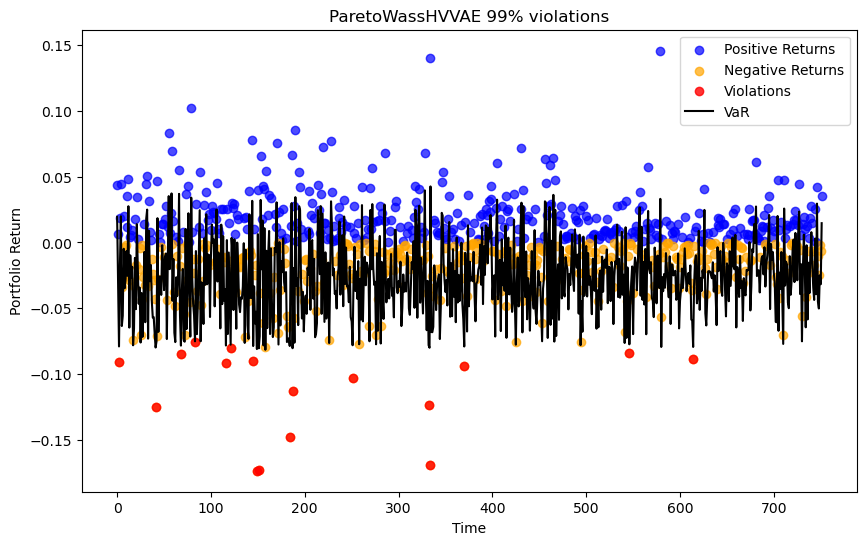

In [346]:
point_forecasts_renorm = np.array(point_forecasts) * data_std[-1] + data_mean[-1]
lower_quantiles_renorm = np.array(lower_quantiles) * data_std[-1] + data_mean[-1]
actual_values_renorm = np.array(actual_values) * data_std[-1] + data_mean[-1]

# Create a DataFrame to store the data
var_df = pd.DataFrame({'Returns': actual_values_renorm, 'VaR': lower_quantiles_renorm}, index=range(len(actual_values_renorm)))

# Separate positive and negative returns
pos = var_df[var_df['Returns'] >= 0]
neg = var_df[var_df['Returns'] < 0]

# Calculate violations
var_df['Violation'] = (var_df['Returns'] < var_df['VaR'])
breakdowns = var_df[var_df['Violation'] == True]

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(pos.index, pos['Returns'], c='blue', alpha=0.7, label='Positive Returns')
plt.scatter(neg.index, neg['Returns'], c='orange', alpha=0.7, label='Negative Returns')
plt.scatter(breakdowns.index, breakdowns['Returns'], c='red', alpha=0.8, label='Violations')
plt.plot(var_df.index, var_df['VaR'], label='VaR', c='black')

plt.legend()
plt.title("ParetoWassHVVAE 99% violations")
plt.xlabel("Time")
plt.ylabel("Portfolio Return")
plt.savefig(f"ParetoWassHVVAE_breakdown_plot.png")
plt.show()

In [351]:
var_df.to_csv('ParetoWassHVVAE_predictions.csv', index=False)

In [349]:
import numpy as np
from scipy.stats import chi2, norm
import pandas as pd

def pof_test(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Kupiec's Proportion of Failure Test (POF). Tests that the number of exceptions
    corresponds to the VaR confidence level.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        p-value of POF test.
    """
    exception = target < var
    t = len(target)
    m = exception.sum()
    p = 1 - alpha
    lr_pof = -2 * (m * np.log(p / (m / t)) + (t - m) * np.log((1 - p) / (1 - m / t)))
    pvalue = 1 - chi2.cdf(lr_pof, df=1)
    return pvalue

def berkowitz_test(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Berkowitz Test assesses the calibration of VaR forecasts. It tests whether the realized
    losses are consistent with the predicted VaR level.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        p-value of the Berkowitz test.
    """
    z = (target - var.mean()) / var.std()
    lr_berkowitz = -2 * (np.log(norm.cdf(z)).sum() - np.log(alpha) * (target < var).sum() - np.log(1 - alpha) * (target >= var).sum())
    pvalue = 1 - chi2.cdf(lr_berkowitz, df=1)
    return pvalue

def quantile_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Quantile loss also known as Pinball loss. Measures the discrepancy between
    true values and a corresponding 1-alpha quantile.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        The average value of the quantile loss function.
    """
    return np.where(target < var, alpha * (var - target), (1 - alpha) * (target - var)).mean()

def quadratic_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99, a: float = 1.0) -> float:
    """
    Quadratic Loss measures the squared difference between the predicted VaR and returns,
    penalizing negative returns with weight (return - VaR)^2 and negative VaRs with
    weight -a * VaR.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter for return - VaR. Default is 0.99.
        a: Weight parameter for negative VaRs. Default is 1.

    Returns:
        Quadratic Loss value.
    """
    return np.where(target < var, (target - var)**2, -a * var).mean()

def smooth_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99, d: float = 25.0) -> float:
    """
    Smooth Loss penalizes observations for which return - VaR < 0 more heavily with weight (1-alpha).

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter. Default is 0.99.
        d: Parameter Default is 25.

    Returns:
        Smooth Loss value.
    """
    return ((alpha - (1 + np.exp(d * (target - var)))**(-1)) * (target - var)).mean()

def tick_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Tick Loss penalizes exceedances with weight alpha and non-exceedances with weight 1 - alpha.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter. Default is 0.99.

    Returns:
        Tick Loss value.
    """
    return ((alpha - (target < var).astype(float)) * (target - var)).mean()

def avg_exceedances(var: np.ndarray, target: np.ndarray) -> float:
    """
    Calculate the average number of exceedances.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.

    Returns:
        Average number of exceedances.
    """
    exceedances = (target < var).sum()
    return exceedances / len(target)

def regulatory_loss(var: np.ndarray, target: np.ndarray) -> float:
    """
    Regulatory Loss Function penalizes exceedances with squared difference and non-exceedances with 0.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.

    Returns:
        Regulatory Loss value.
    """
    return np.where(target < var, (var - target)**2, 0).mean()

def metrics(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> dict:
    metrics_dict = {}

    metrics_dict['POF Test p-value'] = pof_test(var, target, alpha)
    metrics_dict['Berkowitz Test p-value'] = berkowitz_test(var, target, alpha)
    metrics_dict['Quantile Loss'] = quantile_loss(var, target, alpha)
    metrics_dict['Quadratic Loss'] = quadratic_loss(var, target, alpha)
    metrics_dict['Smooth Loss'] = smooth_loss(var, target, alpha)
    metrics_dict['Tick Loss'] = tick_loss(var, target, alpha)
    metrics_dict['Average Exceedances'] = avg_exceedances(var, target)
    metrics_dict['Regulatory Loss'] = regulatory_loss(var, target)

    return metrics_dict

def calculate_metrics_table(target: pd.Series, predictions_dict: dict, alpha: float = 0.99) -> pd.DataFrame:
    metrics_list = [
        'POF Test p-value',
        'Berkowitz Test p-value',
        'Quantile Loss',
        'Quadratic Loss',
        'Smooth Loss',
        'Tick Loss',
        'Average Exceedances',
        'Regulatory Loss'
    ]
    metrics_table = pd.DataFrame(index=metrics_list)

    for model, predictions in predictions_dict.items():
        metrics_dict = metrics(predictions, target, alpha)
        metrics_table[model] = metrics_dict.values()

    return metrics_table

In [350]:
metr = metrics(var_df['VaR'], var_df['Returns'])
pd.DataFrame.from_dict(metr, orient='index', columns=['Value']).to_csv("ParetoWassHVVAE_metrics.csv", index=True)
metr

{'POF Test p-value': 0.002862289418097297,
 'Berkowitz Test p-value': 1.0,
 'Quantile Loss': 0.0010101622203968683,
 'Quadratic Loss': 0.025320569815545695,
 'Smooth Loss': 0.017326079204704494,
 'Tick Loss': 0.025995255803185423,
 'Average Exceedances': 0.022606382978723406,
 'Regulatory Loss': 4.845984917733322e-05}